- title: tutorial: Permutation test: statistical tool to investigate individual data
- date: 2020-01-28 12:00
- category: tutorial
- tags: python, analysis, statistics
- slug: permutation_1
- authors: Julien Hernandez Lallement
- summary: Background and python pipeline to compute permutation tests
- illustration: 2020_01_permutation.jpg

A typical situation regarding solving an experimental question using a data-driven approach involved several groups that differ in several parameters. Say you have data about people that ate chocoloate (Group 1), and some that did not eat chocolate (Group 2). Because of some well funded reason, you think that people that ate chocolate are more likely to ride camels than people that did not eat the chocolate.

### Approaching group data

Now one typical approach in this (a bit crazy) experimental situations would be to look at the difference in camel riding propensity in each group. You could compute the proportions of camel riding actions, or the time spent on a camel, or other dependent variable that might capture the effect you believe to be true.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Text(0.5, 1.0, 'Chocolate Group')

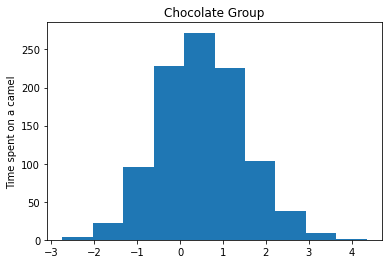

In [3]:
np.random.seed(42)
mean = 0.5; sd=1; sample_size=1000
chocolate_distibution = np.random.normal(loc=mean, scale=sd, size=sample_size)
plt.hist(chocolate_distibution)
plt.ylabel("Time spent on a camel")
plt.title("Chocolate Group")

Text(0.5, 1.0, 'Non Chocolate Group')

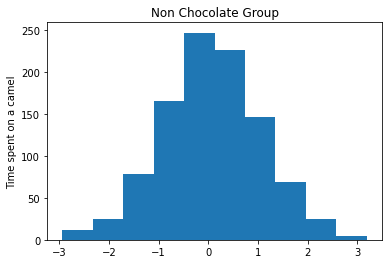

In [4]:
mean = 0; sd=1; sample_size=1000
non_chocolate_distibution = np.random.normal(loc=mean, scale=sd, size=sample_size)
plt.hist(non_chocolate_distibution)
plt.ylabel("Time spent on a camel")
plt.title("Non Chocolate Group")

In [5]:
from scipy import stats
t, p = stats.ttest_ind(a=chocolate_distibution, b=non_chocolate_distibution, axis=0, equal_var=True)
print('t-value = ' + str(t))
print('p-value = ' + str(p))

t-value = 10.146603036863459
p-value = 1.2682721186380258e-23


Well, given that I created uniform distributions centered on quite different means, we are not suprised to see a difference between these two distributions. We can conclude that people that ate chocolate spend more time riding camels that people that did not. 

### Approaching individual data

Now let's assume that for each of these participants, you recorded the choice (Yes or No) to ride a camel. You have repeated measures, at different time points. You know that your groups are significantly different, but what about `within group` variance?

What you might observe is that, at the group level, you do have a increased tendency to ride camels, but within the group, some people have a very high tendency while others are actually no different than the No Chocolate group.

One way to test that would be to use a permutation test, to test each participants against its own choice patterns

### Preparing data for permutation test

Since we are talking about choices, we are looking at a binomial distribution, where say 1 = Decision to ride a camel and 0 = Decision **not** to ride a camel. <br><br>
Let's generate such a distribution for a given participant that would make a 100 decisions:

In [6]:
distr = np.random.binomial(1, 0.7, size=100)
print(distr)

[1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0
 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1]


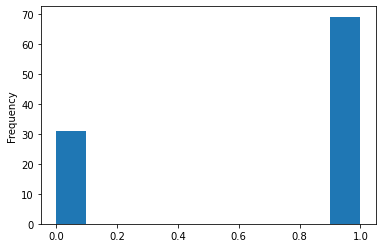

In [7]:
pd.Series(distr).plot(kind='hist')

Here, we can see an example participant from the chocolate group, where as expected, the number of choices to ride a camel are more frequent than choices not to ride a camel

### Generating simulation data

Let's generate such choice patterns for different participants in each group. <br>
Each group will be composed of 20 participants that made 100 choices.<br><br>
We should have measured the initial preference of each participant to like camel riding (maybe some people, for some reason, like it more than others, and that should be corrected for). <br>
We thus will generate a baseline phase (before giving them chocolate) and an experimental phase (after giving them chocolate in the chocolate group, and another neutral substance in the non chocolate group).<br><br>
A few points: <br>
1) I will generate biased distributions that follow the pattern found before, i.e., that people that ate chocolate are more likely to ride a camel. <br>
2) I will produce baseline choices levels similar between the two groups, to make the between group comparison statistically valid.<br>
3) I will include in each of these groups a few participants that behave according to the pattern in the other group, so that we can use a permutation method to detect these guys.

I define a function that generate this data

In [17]:
def generate_simulation_data(nParticipants, nChoicesBase, nChoicesExp, binomial_ratio):
    """
    Generates a simulation choice distribution based on parameters
    Function uses a binomial distribution as basis
    """
    # Pre Allocate
    group = pd.DataFrame()
    # Loop over participants. For each draw a binonimal choice distribution
    for i in range (0,nParticipants):
        # Compute choices to ride a camel before drinking, same for both groups (0.5) 
        choices_before = np.random.binomial(1, 0.4, size=nChoicesBase) 
        # Compute choices to ride a camel after drinking, different per group (defined by binomial ratio)
        choices_after  = np.random.binomial(1, np.random.choice(binomial_ratio,replace=True), size=nChoicesExp)
        # Concatenate
        choices = np.concatenate([choices_before, choices_after])
        # Store in dataframe
        group.loc[:,i] = choices
    return group.T
    

In [9]:
chocolate_grp = generate_simulation_data(nParticipants=20, nChoicesBase=20, nChoicesExp=100, binomial_ratio=[0.5,0.6,0.7,0.8,0.9])

In [10]:
chocolate_grp.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
15,0,1,0,1,0,0,0,1,1,1,...,0,1,0,1,1,1,1,1,0,0
17,0,0,0,1,0,1,1,0,0,0,...,1,1,1,1,1,0,1,1,1,0
8,0,0,1,1,0,1,0,0,1,0,...,1,1,1,0,1,1,1,0,1,1
3,0,0,0,0,0,1,0,1,1,0,...,0,1,1,1,1,1,1,1,0,1
4,0,0,1,0,0,0,1,0,1,0,...,1,1,0,1,1,1,0,1,1,1


We can now quickly plot the all summed choices for riding a camel for each of these participants to verify that indeed, we have a few indifferent ones (data points around value = 50), but most of them have a preference, more or less pronounced, to ride a camel.

In [14]:
def plot_group_hist(data, title):
    data.sum(axis=1).plot(kind='hist')
    plt.ylabel("Number of participants")
    plt.xlabel("Repeated choices to ride a camel")
    plt.title(title)

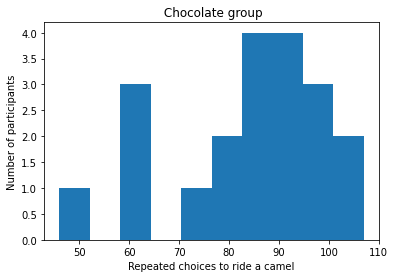

In [15]:
plot_group_hist(chocolate_grp, title=' Chocolate group')

Instead of simply summing up the choides to ride a camel, let's compute a single value per participant that would reflect their preference or aversion to camel ride.

I will be using the following equation, that basically computes a score between [-1;+1], +1 reflecting a complete switch for camel ride preference after drinking, and vice versa.

\begin{equation*}
\left (participant score \right) = \left( \ \frac{\sum CamelChoice_{exp} - \sum CamelChoice_{base}}{\sum CamelChoice_{exp} + \sum CamelChoice_{base}} \right)    
\end{equation*}

In [16]:
def indiv_score(data):
    """
    Calculate a normalized score for each participant
    Baseline phase is taken for the first 20 decisions
    Trials 21 to 60 are used as actual experimental choices
    """
    # Baseline is the first 20 choices, experimental is from choice 21 onwards
    score = ((data.loc[20:60].mean() - data.loc[0:19].mean())
        / (data.loc[20:60].mean() + data.loc[0:19].mean())
        )
    return score

def compute_indiv_score(data):
    """
    Compute score for all individuals in the dataset
    """
    # Pre Allocate
    score = pd.DataFrame(columns = ['score'])
    # Loop over individuals to calculate score for each one
    for i in range(0,len(data)):
        # Calculate score
        curr_score = indiv_score(data.loc[i,:])
        # Store score
        score.loc[i,'score'] = curr_score
    return score

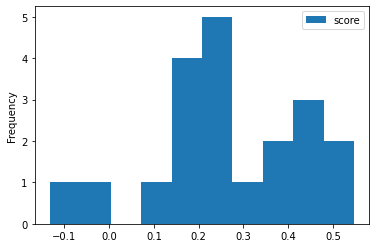

In [29]:
score_chocolate = compute_indiv_score(chocolate_grp)
score_chocolate.plot(kind='hist')

We can interpret these scores as suggesting that asome individuals showed >50% higher preference to ride a camel after drinking chocolate, while the majority showed an increase in preference of approximately 20/40%. Note how a few individuals, altough pertaining to this group, show an almost oppposite pattern.

Now let's generate and look at data for the control, non chocolate group

In [30]:
# Note that I am not using values strongly below 0.5 for the non chocolate group
# Doing so would generate participants that **avoid** riding camels
non_chocolate_grp = generate_simulation_data(nParticipants=20, nChoicesBase=20, nChoicesExp = 100, binomial_ratio=[0.3, 0.4,0.5])

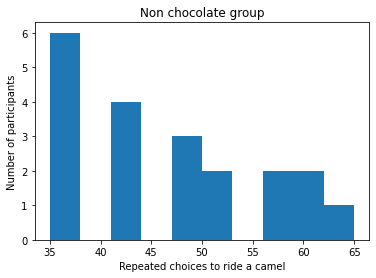

In [31]:
plot_group_hist(non_chocolate_grp, title='Non chocolate group')

We can see already that the distribution is centered at a much lower level, maybe around 55% preference for riding a camel.

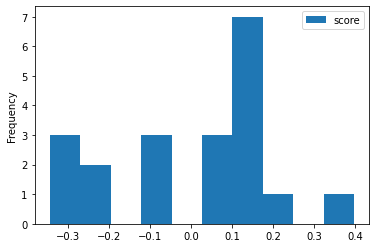

In [32]:
score_non_chocolate = compute_indiv_score(non_chocolate_grp)
score_non_chocolate.plot(kind='hist')

OK! Now we have our participants. Let's run a permutation test to detect which participants were significantly preferring riding a camel in each group. Based on the between group statistics, we expect that number of be (maybe significantly, we'll see that) higher in the chocolate than in the non chocolate group.

### Permutation test

A permutation test consists in shuffling the data, within each participant, to create a new distribution of data that would reflect a virtual, but given the data possible, distribution. That operation is performed many times to generate a virtual distribution against which the actual true data is compared to. 

In our case, we will shuffle the data of each participant between the initial measurement (baseline likelihood to ride a camel) and the post measurement phase (same measure after drinking, in each group). 

The function below runs a permutation test for all participants in a given group.
For each participant, it shuffles the choice data nReps times, and calculate a confidence interval (you can define whether you want it one or two sided) and checks the location of the real choice data related to this CI. When outside of it, the participant is said to have a significant preference for camel riding.

In [33]:
def run_permutation(data, direct='two-sided', nReps=1000, print_output=False):
    """
    Run a permutation test.
    For each permutation, a score is calculated and store in an array.
    Once all permutations are performed for that given participants, the function computes the real score
    It then compares the real score with the confidence interval.
    
    The ouput is a datafram containing all important statistical information.
    """
    # PreAllocate significance
    output=pd.DataFrame(columns=['Participant', 'Real_Score', 'Lower_CI', 'Upper_CI', 'Significance'])

    for iParticipant in range(0,data.shape[0]):
        # Pre Allocate
        scores = pd.Series('float')
        # Start repetition Loop
        if print_output == True:
            print('Participant #' +str(iParticipant))
        output.loc[iParticipant, 'Participant'] = iParticipant
        for iRep in range(0,nReps):
            # Store initial choice distribution to compute real true score
            initial_dat = data.loc[iParticipant,:]
            # Create a copy
            curr_dat = initial_dat.copy()
            # Shuffle data
            np.random.shuffle(curr_dat)
            # Calculate score with shuffled data
            scores[iRep] = indiv_score(curr_dat)
            
        # Sort scores to compute confidence interval
        scores = scores.sort_values().reset_index(drop=True)
        # Calculate confidence interval bounds, based on directed hypothesis
        if direct == 'two-sided':
            upper = scores.iloc[np.ceil(scores.shape[0]*0.95).astype(int)]
            lower = scores.iloc[np.ceil(scores.shape[0]*0.05).astype(int)]
        elif direct == 'one-sided':
            upper = scores.iloc[np.ceil(scores.shape[0]*0.975).astype(int)]
            lower = scores.iloc[np.ceil(scores.shape[0]*0.025).astype(int)]    

        output.loc[iParticipant, 'Lower_CI'] = lower
        output.loc[iParticipant, 'Upper_CI'] = upper
        if print_output == True:
            print ('CI = [' +str(np.round(lower,decimals=2)) + ' ; ' + str(np.round(upper,decimals=2)) + ']')
        # Calculate real score
        real_score = indiv_score(initial_dat)
        output.loc[iParticipant, 'Real_Score'] = real_score
        if print_output == True:
            print('Real score = ' + str(np.round(real_score,decimals=2)))
        # Check whether score is outside CI bound
        if (real_score < upper) & (real_score > lower):
            output.loc[iParticipant, 'Significance'] =0
            if print_output == True:
                print('Not Significant')
        elif real_score >= upper:
            output.loc[iParticipant, 'Significance'] =1
            if print_output == True:
                print('Significantly above')
        else: output.loc[iParticipant, 'Significance']  = -1; print('Significantly below')
        if print_output == True:
            print('')
    return output

In [34]:
output_chocolate = run_permutation(chocolate_grp, direct='two-sided', nReps=100, print_output=False)
output_chocolate

,Participant,Real_Score,Lower_CI,Upper_CI,Significance
0,0,0.188119,-0.249707,0.270648,0
1,1,0.173236,-0.10899,0.16041,1
2,2,0.451767,-0.119879,0.0989011,1
3,3,0.380798,-0.175627,0.107814,1
4,4,0.23839,-0.137134,0.135442,1
5,5,0.468683,-0.10899,0.121187,1
6,6,0.216334,-0.0868925,0.0922509,1
7,7,0.203883,-0.134948,0.188119,1
8,8,-0.044586,-0.211823,0.288724,0
9,9,0.24424,-0.13215,0.203883,1


In [35]:
output_non_chocolate = run_permutation(non_chocolate_grp, direct='two-sided', nReps=100, print_output=False)
output_non_chocolate

Significantly below


,Participant,Real_Score,Lower_CI,Upper_CI,Significance
0,0,-0.0789474,-0.233926,0.299145,0
1,1,0.0646388,-0.261538,0.207729,0
2,2,-0.0493601,-0.284116,0.444695,0
3,3,0.397059,-0.233926,0.299145,1
4,4,0.145833,-0.182692,0.188119,0
5,5,-0.344262,-0.211823,0.322314,-1
6,6,0.13943,-0.261538,0.282799,0
7,7,0.0845295,-0.305355,0.374046,0
8,8,-0.115646,-0.297012,0.357702,0
9,9,0.16041,-0.223881,0.23839,0


We can see that, as expected from the way we compute the distributions ,we have much more participants that significantly increased their camel ride preference after the baseline measurement in the chocolate group. <br>

That is much less likely in the non chocolate group, where we even have one significant decrease in preference (participant #11)

### Final words

That was it. Once this analysis is done, you could look at what other, **unrelated** variables, might differ between the two groups and potentially explain part of the variance in the statistics. 
<br><br>
I hope that you found this tutorial helpful.
Don't hesitate to contact me if you have any questions or comments!

Data and notebooks are in this repo: https://github.com/juls-dotcom/permutation